In [1]:
from datetime import datetime, timedelta
from pytz import timezone
import math
import sys
import os

In [2]:
# check mannually
check_days_back = 7

# Define Variables and Functions

In [3]:
deployment = "https://vip.domino.tech"
model_version_id = "5bb6a0d3c9e77c0007cdd20a"
log_file = "churn-model-api-logs.txt"
output_file = log_file + ".gz"

In [4]:
def get_timestamp_ms(year, month, day, hour, minute):
    dt = datetime(year=year, month=month, day=day, hour=hour, minute=minute, tzinfo=timezone("US/Pacific"))
    ts_ms = math.floor(dt.timestamp())*1000
    print(ts_ms)
    return(ts_ms)

In [5]:
NOW = True
ZEROSTART = True

In [6]:
if (NOW):
    endMillis = math.floor(datetime.now(timezone("US/Pacific")).timestamp())*1000
else:
    endMillis = get_timestamp_ms(2018, 10, 4, 16, 28)
endMillis

1565035706000

In [7]:
if (ZEROSTART):
    startMillis = 0
else:
    startMillis = get_timestamp_ms(2018, 10, 5, 0, 0)
startMillis

0

# Construct CURL String

In [8]:
get_logs = "curl --header \"accept: application/x-ndjson\" --header \"X-Domino-Api-Key: " \
            + os.environ['DOMINO_USER_API_KEY'] \
            + "\" '" + deployment \
            + "/v4/modelManager/" + model_version_id \
            + "/logs?startMillis=" + str(startMillis) \
            + "&endMillis=" + str(endMillis) + "'" \
            + " --output " + output_file

In [9]:
print(get_logs)

curl --header "accept: application/x-ndjson" --header "X-Domino-Api-Key: 3569218337b1dd885ca0a72306eca366c654381121c480a2089b927890718b26" 'https://vip.domino.tech/v4/modelManager/5bb6a0d3c9e77c0007cdd20a/logs?startMillis=0&endMillis=1565035706000' --output churn-model-api-logs.txt.gz


In [10]:
! rm $log_file
! $get_logs
! gunzip $output_file

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1170    0  1170    0     0     27      0 --:--:--  0:00:42 --:--:--   146


# Define Historical File

In [11]:
#log_file = "/mnt/data/churn-model-api-logs-save.txt"
historical_file = "/mnt/data/churn_model_logs.txt"

# Inspect Log File

In [12]:
# view raw text

f = open(log_file, "r")
data = f.read()
i=1
printlist = data.split("\n")
for line in printlist:
    if i <= 2: print(line)
    i += 1

{"timeStamp": "20190803T210009.354Z", "requestId": "8PMRUDQ0A591HIWZ", "input": {"data": {"dropperc": 0.0010233135526798926, "mins": 435.6282886798482, "consecmonths": 31.197688703773473, "income": 127.22087549162819}}, "httpResponse": 200, "output": [0.0005365332047161695], "timingMillis": 0}
{"timeStamp": "20190803T230009.282Z", "requestId": "H7QR13NE85ZLMF9J", "input": {"data": {"dropperc": 0.003399809336999424, "mins": 614.8524223291514, "consecmonths": 22.991838002053605, "income": 81.57714521480337}}, "httpResponse": 200, "output": [0.00010566561245028715], "timingMillis": 1}


# Parse Log File

In [13]:
# parse with json library
# view first line

import json
# one line at a time in a list
data = []
for line in open(log_file, 'r'):
    data.append(json.loads(line))
data[0]

{'timeStamp': '20190803T210009.354Z',
 'requestId': '8PMRUDQ0A591HIWZ',
 'input': {'data': {'dropperc': 0.0010233135526798926,
   'mins': 435.6282886798482,
   'consecmonths': 31.197688703773473,
   'income': 127.22087549162819}},
 'httpResponse': 200,
 'output': [0.0005365332047161695],
 'timingMillis': 0}

In [14]:
# load into df
# view first rows

import pandas as pd
df = pd.read_json(json.dumps(data))
df.head()

,httpResponse,input,output,requestId,timeStamp,timingMillis
0,200,"{'data': {'dropperc': 0.001023313552679, 'mins...",[0.0005365332047160001],8PMRUDQ0A591HIWZ,2019-08-03 21:00:09.354,0
1,200,"{'data': {'dropperc': 0.003399809336999, 'mins...",[0.00010566561245],H7QR13NE85ZLMF9J,2019-08-03 23:00:09.282,1
2,200,"{'data': {'dropperc': 0.029219062192467, 'mins...",[2.178622134340524e-05],XFRLAU9QE4GKWDS0,2019-08-04 09:00:10.580,0
3,200,"{'data': {'dropperc': 0.005458482858791001, 'm...",[0.00023641065314300002],5FL74OWS3AKZI028,2019-08-04 21:00:09.475,0
4,200,"{'data': {'dropperc': 0.00010216088947600001, ...",[0.000820032669023],X8FVZNBT93QY0UPO,2019-08-04 23:00:09.914,0


In [15]:
# flatten 'input'
# view first rows

from pandas.io.json import json_normalize
input_df = json_normalize(df.input)
input_df.head()

,data.consecmonths,data.dropperc,data.income,data.mins
0,31.197689,0.001023,127.220875,435.628289
1,22.991838,0.003400,81.577145,614.852422
2,8.873301,0.029219,73.298444,331.004428
3,25.102109,0.005458,46.154090,447.328104
4,26.500474,0.000102,89.263260,276.032627


In [16]:
# flatten 'output'
# not formatted right for json_normalized
# use string functions
# view pre and post processing

print("First line of 'output': " + str(df.output.values[0]))

s=""
for v in df.output.values:
     s+=str(v) + ","
res=[s]
res[0] = res[0][:-1]
res[0] = res[0].replace("{'churn_Y': ","")
res[0] = res[0].replace("}","")
res[0] = res[0].replace("nan","")
res[0] = res[0].replace("[","")
res[0] = res[0].replace("]","")
out_list = res[0].split(",")
out_df = pd.DataFrame({'output':out_list})
out_df = out_df.apply(pd.to_numeric, errors='ignore')
out_df.head()

First line of 'output': [0.0005365332047160001]


,output
0,0.000537
1,0.000106
2,0.000022
3,0.000236
4,0.000820


In [17]:
# join input and output back in
# view first rows

df = df.drop(['input'],axis=1)
df = df.drop(['output'],axis=1)
collist = df.columns.values.tolist()
df = df[collist].join(input_df).join(out_df)

# Parse Historical File

In [18]:
# grab historical data

import json
# one line at a time in a list
data_baseline = []
for line in open(historical_file, 'r'):
    data_baseline.append(json.loads(line))
    
import pandas as pd
df_baseline = pd.read_json(json.dumps(data_baseline))

from pandas.io.json import json_normalize
input_df_baseline = json_normalize(df_baseline.input)

s=""
for v in df_baseline.output.values:
     s+=str(v) + ","
res=[s]
res[0] = res[0][:-1]
res[0] = res[0].replace("{'churn_Y': ","")
res[0] = res[0].replace("}","")
res[0] = res[0].replace("nan","")
res[0] = res[0].replace("[","")
res[0] = res[0].replace("]","")
out_list_baseline = res[0].split(",")
out_df_baseline = pd.DataFrame({'output':out_list_baseline})
out_df_baseline = out_df_baseline.apply(pd.to_numeric, errors='ignore')

df_baseline = df_baseline.drop(['input'],axis=1)
df_baseline = df_baseline.drop(['output'],axis=1)
collist = df_baseline.columns.values.tolist()
df_baseline = df_baseline[collist].join(input_df_baseline).join(out_df_baseline)

# Compare Log and Historical

In [19]:
# libraries for graphing

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.dates as mdates
%matplotlib inline
from scipy.stats import kurtosis

In [20]:
# sort both dfs

df = df.sort_values(by=['timeStamp'])
df_baseline = df_baseline.sort_values(by=['timeStamp'])

In [21]:
df_baseline.head()

,httpResponse,requestId,timeStamp,timingMillis,data.consecmonths,data.dropperc,data.income,data.mins,output
7926,200,5OB7X3CRN0M8SAJF,2016-01-01 05:29:46.099,0,20,0.0210,79.4,525,0.0007
7925,200,5OB7X3CRN0M8SAJF,2016-01-01 06:42:38.623,0,27,0.0135,108.1,445,0.0006
7924,200,5OB7X3CRN0M8SAJF,2016-01-01 07:52:49.891,0,20,0.0193,78.9,466,0.0002
7923,200,5OB7X3CRN0M8SAJF,2016-01-01 08:35:18.523,0,33,0.0098,72.2,512,0.0005
7922,200,5OB7X3CRN0M8SAJF,2016-01-01 09:36:04.824,0,21,0.0282,83.7,390,0.0001


In [22]:
test=~df['data.mins'].isnull()

In [23]:
df[test]['data.mins'].values

array([435.62828868, 614.85242233, 331.00442783, 447.32810439,
       276.03262718, 484.0200158 , 242.        , 242.        ,
       242.        , 242.        , 242.        , 242.        ,
       242.        , 242.        , 242.        ])

In [24]:
# function to make a comparison graph

def logplot(var, check_days_back):
    # set data inputs
    yhist = pd.DataFrame(df_baseline[var]).dropna().values
    y_not_nan = ~df[var].isnull()
    y = df[y_not_nan][var].values
    x = mdates.date2num(df[y_not_nan]['timeStamp'])
    numobs = pd.DataFrame(df[var]).shape[0]
        
    histymax = max(yhist)
    histymin = min(yhist)
    histysigma3 = np.std(yhist) * 3
    histymean = np.mean(yhist)
    histy999 = np.percentile(yhist, 99.9)
    histy001 = np.percentile(yhist, 0.1)

    yOOB = np.logical_or(y > histymax, y < histymin)
    yWarn = np.logical_and(np.logical_or(y > histy999, y < histy001),~yOOB)
    
    # check for OOB values and set exit flag
    check_date = max(df.timeStamp)-timedelta(check_days_back)
    check_df = df[(df['timeStamp'] > check_date)]
    check_max = max(check_df[var])
    check_min = min(check_df[var])
    exit_flag = False
    if (check_max > histymax) or (check_min < histymin):
        exit_flag = True
    
    # special sauce
    bins = int(min(max(-1/10 * abs(abs(kurtosis(pd.DataFrame(df_baseline[var]).dropna().values)) - 3)**2
                       + 20, 5),30))
 

    # set limits
    ymax = max(histymax,max(y))
    ymin = min(histymin,min(y))
    binwidth = (ymax - ymin)/bins
    #ylim_up = (int(ymax/binwidth) + 1) * binwidth
    #ylim_lw = (int(ymin/binwidth) - 1) * binwidth
    ylim_up = ymax + binwidth
    ylim_lw = ymin - binwidth
    # no labels (used for trend line)
    nullfmt = NullFormatter()         

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02
    rect_plt = [left, bottom, width, height]
    rect_histy = [left_h-.975, bottom, 0.3, height]

    # start with a rectangular Figure
    plt.figure(1, figsize=(8, 5))

    # set shape
    axHisty = plt.axes(rect_histy)
    ax = plt.axes(rect_plt)

    # trend line
    ax.yaxis.set_major_formatter(nullfmt)
    ax.set_ylim((ylim_lw, ylim_up))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    ax.axes.get_yaxis().set_ticks([])
    #ax.plot(x, y[~yOOB], 'o-')


    #ax.hold(True)

    # draw some lines behind the scatter plots (using zorder)
    ax.plot(x, y)

    # scatter valid (not warning) points in blue (c='b')
    ax.scatter(x[~yOOB], y[~yOOB])

    # scatter warning points in red (c='r')
    if np.any(y[yWarn]):
        plt.scatter(x[yWarn], y[yWarn], label='warning', c='m')
    if np.any(y[yOOB]):
        plt.scatter(x[yOOB], y[yOOB], label='out of bounds', c='r')


    #min/max lines
    ax.axhline(y=histymax, color='r', linestyle='-', linewidth = 1, label="historical max/min")
    ax.axhline(y=histymin, color='r', linestyle='-', linewidth = 1)
    tooclose = (histymax - histymin)/30
    if histy999 < histymax - tooclose and histy999 < histymax:
        ax.axhline(y=histy999, color='m', linestyle='--', linewidth = 1, label = "1/1000 event")
        if histy001 > histymin + tooclose and histy001 > histymin:
            ax.axhline(y=histy001, color='m', linestyle='--', linewidth = 1)
        elif histy001 > histymin + tooclose and histy001 > histymin:
            ax.axhline(y=histy001, color='m', linestyle='--', linewidth = 1, label = "1/1000 event")

    # histogram
    #bins = np.arange(ylim_lw, ylim_up + binwidth, binwidth)
    (n, binsout, patches) = axHisty.hist(yhist, bins=bins, orientation='horizontal')
    axHisty.set_ylim(ylim_lw,ylim_up)
    axHisty.set_xlim(-max(n)/20,max(n)+max(n)/20)

    plt.title("Trend of '" + var + "'\nFor Selected Model Runs\nCompared to Baseline", {'fontsize': 16})
    plt.xticks(rotation=90)
    lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)    
    plt.savefig('/mnt/results/' + var + '.png', format='png', bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()
    plt.clf()
    return(exit_flag)

In [25]:
# lists to keep track of vars for error statement and if we should exit at all
oob_vars = list()
exit_status = list()

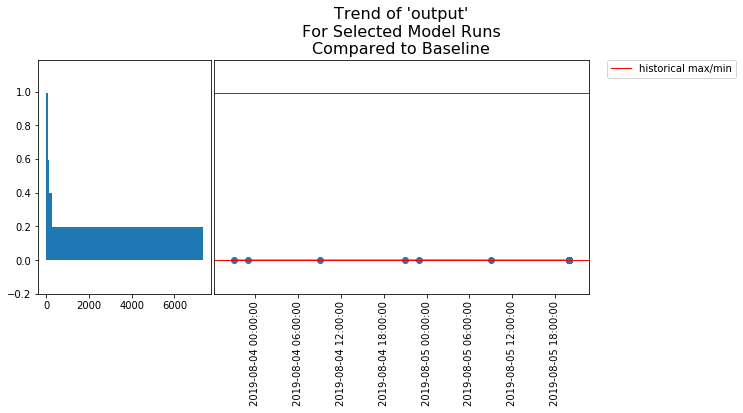

<Figure size 432x288 with 0 Axes>

In [26]:
check = logplot('output', check_days_back)
exit_status.append(check)
if exit_status[len(exit_status)-1]:
    oob_vars.append('output')

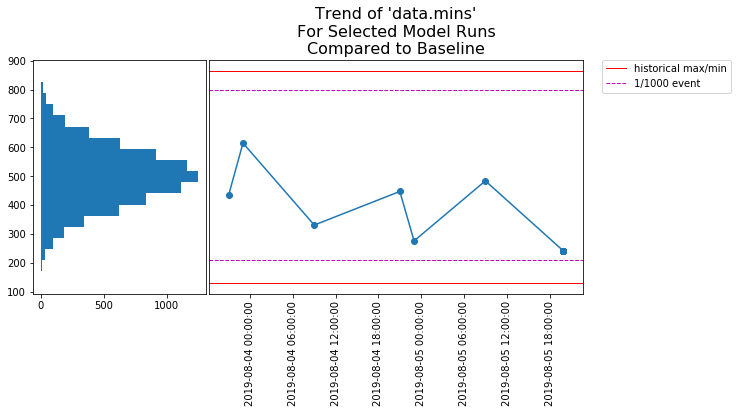

<Figure size 432x288 with 0 Axes>

In [27]:
check = logplot('data.mins', check_days_back)
exit_status.append(check)
if exit_status[len(exit_status)-1]:
    oob_vars.append('data.mins')

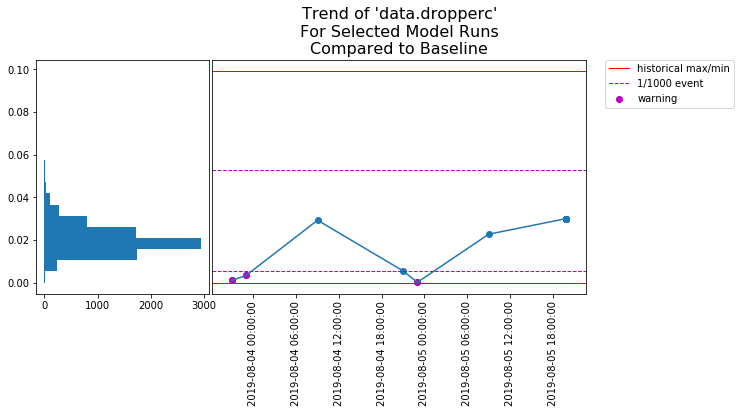

<Figure size 432x288 with 0 Axes>

In [28]:
check = logplot('data.dropperc', check_days_back)
exit_status.append(check)
if exit_status[len(exit_status)-1]:
    oob_vars.append('data.dropperc')

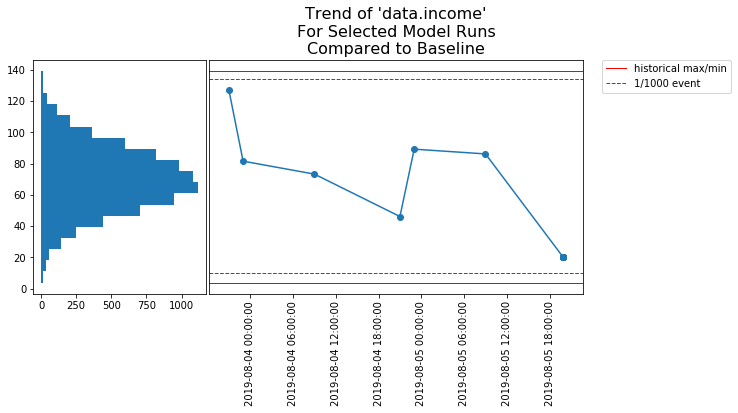

<Figure size 432x288 with 0 Axes>

In [29]:
check = logplot('data.income', check_days_back)
exit_status.append(check)
if exit_status[len(exit_status)-1]:
    oob_vars.append('data.income')

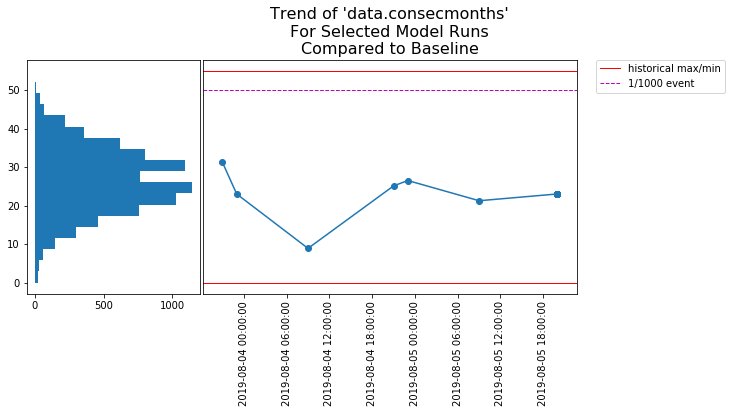

<Figure size 432x288 with 0 Axes>

In [30]:
check = logplot('data.consecmonths', check_days_back)
exit_status.append(check)
if exit_status[len(exit_status)-1]:
    oob_vars.append('data.consecmonths')

In [31]:
var_list = ""
i=1
for var in oob_vars:
    if i == 1:
        var_list = var_list + var
    else:
        var_list = var_list + ", " + var
    i += 1

In [32]:
oob_vars

[]

In [33]:
exit_status

[False, False, False, False, False]

In [34]:
if any(exit_status):
    sys.exit("Out of bounds values in: " + var_list)